In [2]:
import pandas as pd
from datetime import datetime,timedelta
from lite.parameters_lite import Parameters
from lite.backtester_lite import Backtester
from lite.transformer_lite import Transformer
from processor.processor import Processor as p
from alpaca_api.alpaca_api import AlpacaApi
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
alp = AlpacaApi()

In [4]:
sp100 = pd.read_html("https://en.wikipedia.org/wiki/S%26P_100",attrs={"id":"constituents"})[0]
sp100.rename(columns={"Symbol":"ticker","Sector":"GICS Sector"},inplace=True)

In [5]:
backtest_years = 1
current = False
extract_date = datetime.now() - timedelta(days=(backtest_years+1)*365.25)
start_date = datetime.now() - timedelta(days=backtest_years*365.25)
end_date = datetime.now()
lookbacks = [5,20,60]
tickers = sp100["ticker"]
positions = len(list(sp100["GICS Sector"].unique()))

In [6]:
parameters = Parameters.parameters_lite(lookbacks)

In [7]:
simulation = []
for ticker in tqdm(tickers):
    try:
        ticker_data = alp.get_ticker_data(ticker,extract_date,end_date)
        ticker_data = Transformer.transform(ticker_data,lookbacks,current)
        simulation.append(ticker_data.dropna())
    except Exception as e:
        print(ticker,str(e))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:11<00:00,  8.72it/s]


In [8]:
final = pd.concat(simulation).merge(sp100[["ticker","GICS Sector"]],how="left")

In [9]:
all_trades = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        trades = Backtester.backtest(final.copy(),iteration,parameter,current)
        all_trades.append(trades)
    except Exception as e:
        print(str(e))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.73it/s]


In [10]:
analysis = pd.concat(all_trades)
analysis["return"] = analysis["return"] + 1

In [11]:
report = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        iteration_trades = analysis[analysis["iteration"]==iteration]
        iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
        cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
        for i in range(positions):
            if float(i) not in cumulative.columns:
                cumulative[float(i)] = 1
        cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
        iter_report = cumulative.cumprod().iloc[-1]
        for key in parameter.keys():
            iter_report[key] = parameter[key]
        iter_report["iteration"] = iteration
        report.append(iter_report[["pv","iteration"] + list(parameter.keys())])
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.05it/s]


In [12]:
iteration_trades

,date,ticker,signal,return,position,iteration,strategy,value,lookback
1683,2022-08-23 04:00:00,LIN,-0.064074,0.996446,0,11,window,False,60
1684,2022-08-23 04:00:00,XOM,-0.014727,1.005904,1,11,window,False,60
1685,2022-08-23 04:00:00,AMT,0.040963,0.997163,2,11,window,False,60
1686,2022-08-23 04:00:00,BLK,0.104986,1.004947,3,11,window,False,60
1687,2022-08-23 04:00:00,DHR,0.125557,1.003146,4,11,window,False,60
...,...,...,...,...,...,...,...,...,...
3867,2023-08-21 04:00:00,MET,0.174109,0.994270,6,11,window,False,60
3868,2023-08-21 04:00:00,CHTR,0.199848,0.987500,7,11,window,False,60
3869,2023-08-21 04:00:00,CAT,0.226954,0.991641,8,11,window,False,60
3870,2023-08-21 04:00:00,LLY,0.227129,1.006254,9,11,window,False,60


In [13]:
performance = pd.DataFrame(report)

In [14]:
performance.sort_values("pv",ascending=False).head(5)

position,pv,iteration,strategy,value,lookback
198,1.343995,10,window,False,20
198,1.232325,5,rolling,False,60
198,1.208714,4,rolling,False,20
198,1.131986,3,rolling,False,5
198,1.127622,11,window,False,60


In [15]:
iteration = performance.sort_values("pv",ascending=False).iloc[0]["iteration"]
parameter = parameters[iteration]
iteration_trades = analysis[analysis["iteration"]==iteration]
iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
cumulative["pv"] = cumulative["pv"].cumprod()

In [16]:
cumulative.tail()

position,date,0,1,2,3,4,5,6,7,8,9,10,pv
194,2023-08-14 04:00:00,0.990338,0.985504,0.966594,0.993581,0.999718,0.974502,0.972107,0.989559,0.974801,1.001872,1.016022,1.356674
195,2023-08-15 04:00:00,0.958740,1.002875,0.989793,0.996077,0.991330,0.998372,0.984325,0.992468,0.990054,0.996940,0.999305,1.344375
196,2023-08-16 04:00:00,0.990561,1.000221,1.010128,0.992820,1.002919,1.000142,0.973934,1.019372,0.976473,0.997842,0.984293,1.338106
197,2023-08-17 04:00:00,1.000794,1.005513,1.002971,1.014388,0.998216,1.005332,1.015129,0.982767,0.989737,1.009397,1.016311,1.343040
198,2023-08-21 04:00:00,1.005828,1.000781,0.996381,0.989662,0.994270,1.000276,1.009980,0.996620,0.997608,1.010166,1.006254,1.343995


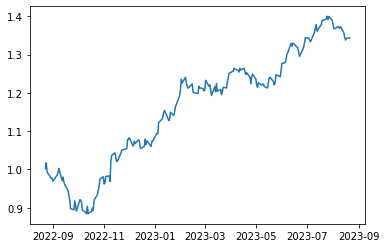

In [17]:
plt.plot(cumulative["date"],cumulative["pv"])

In [18]:
pd.DataFrame([parameter]).to_csv("parameter.csv")